In [17]:
import astropy.units as u

from generate_priors_TOI import grab_all_priors
from RV_mini_pipeline import remake_rvfile
from generate_supporting_files import *
import sys
sys.path.insert(0, '/Users/jack/Research/pipelines/exofast_tools/scripts/lightcurve_pipeline/')
from lightcurve_pipeline import create_light_curve
import pandas as pd
import lightkurve as lk
import os

## System parameters

In [19]:
toi = '5925'
ticid = '345193111'
rv_instrument = 'tres'
outpath = f'/Users/jack/Research/meep3/fits/toi{toi}/'

if os.path.exists(outpath) == False:
    os.makedirs(outpath)

## Downloading and formatting RVs
Ensure that the units and output filename are correct for the given instrument. Usually, CHIRON RVs are in km/s and TRES RVs are in m/s

In [20]:
path = outpath + f'toi{toi}.spctable'

with open('tres_password.txt', 'r') as file:
    password = file.read().replace('\n', '')

remake_rvfile(path, u.m/u.s, output_filename=outpath+f'{ticid}.{rv_instrument.upper()}.rv', 
              download_rvs=True, username='schulte', password=password, ticid=ticid, instrument=rv_instrument, verbose=False)

## Downloading TESS lightcurves
Run the first cell to see what lightcurves are available, and then modify and run the next cell to download the selected lightcurve. Make sure that you are downloading the highest cadence lightcurves available and that the data are of good quality.

After running the initial EXOFAST fit, you can check for a secondary eclipse by re-running these cells with the correct parameters.

In [21]:
lk.search_lightcurve(f'TIC {ticid}')

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 82,2024,SPOC,120,345193111,0.0
1,TESS Sector 55,2022,TESS-SPOC,600,345193111,0.0
2,TESS Sector 55,2022,QLP,600,345193111,0.0
3,TESS Sector 82,2024,QLP,200,345193111,0.0


Sector: 82. Exposure time: 120 seconds.
period:  6.1606297 duration:  2.218 h tc:  2459814.55
per-point error value 0.003527450656735686


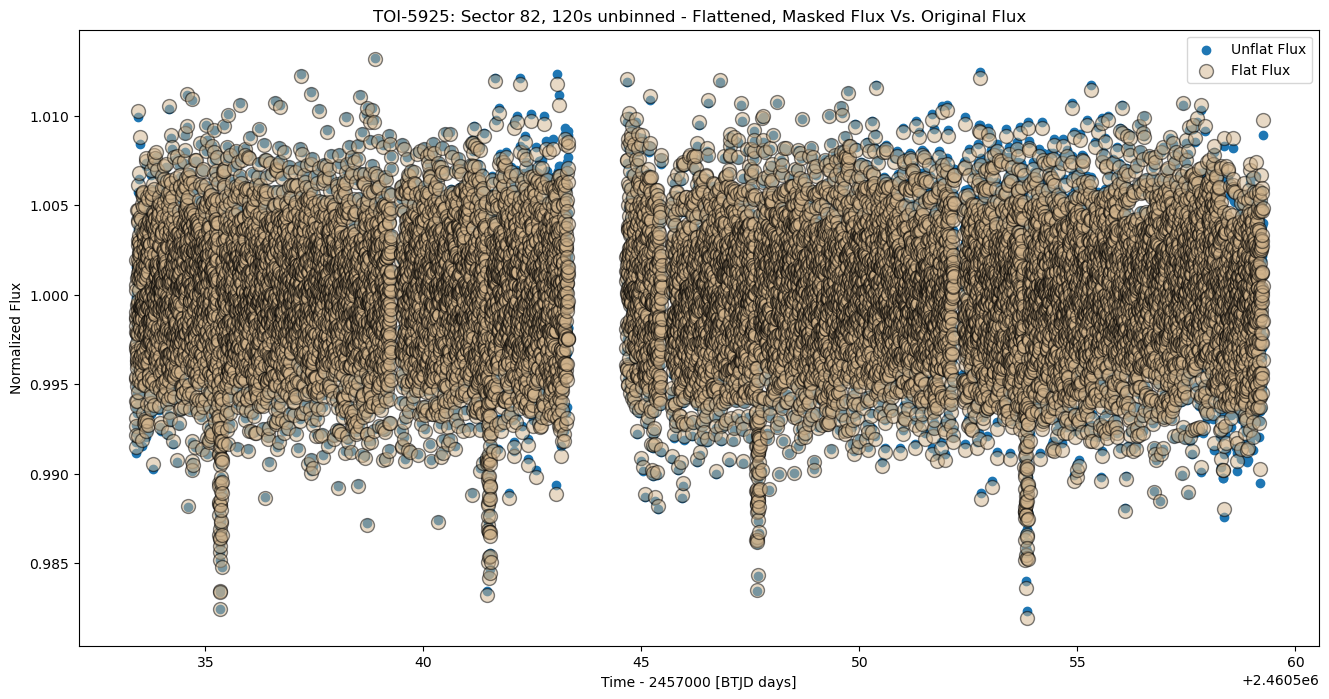

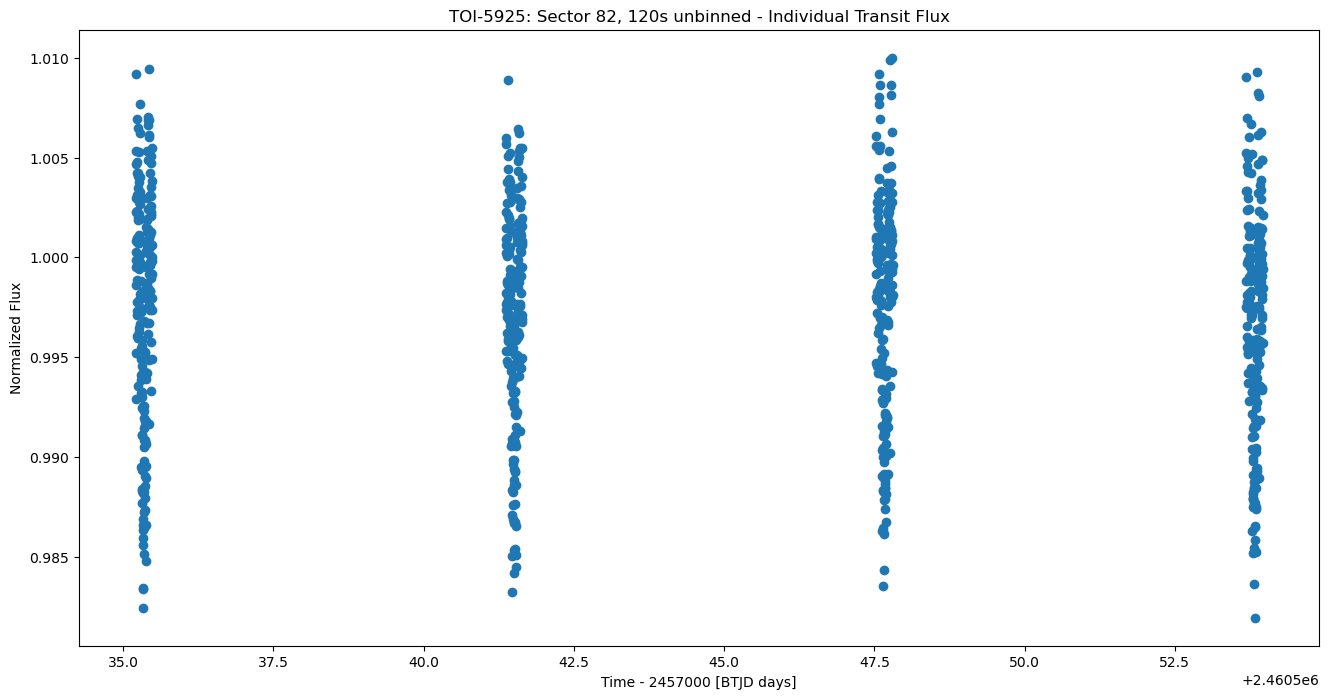

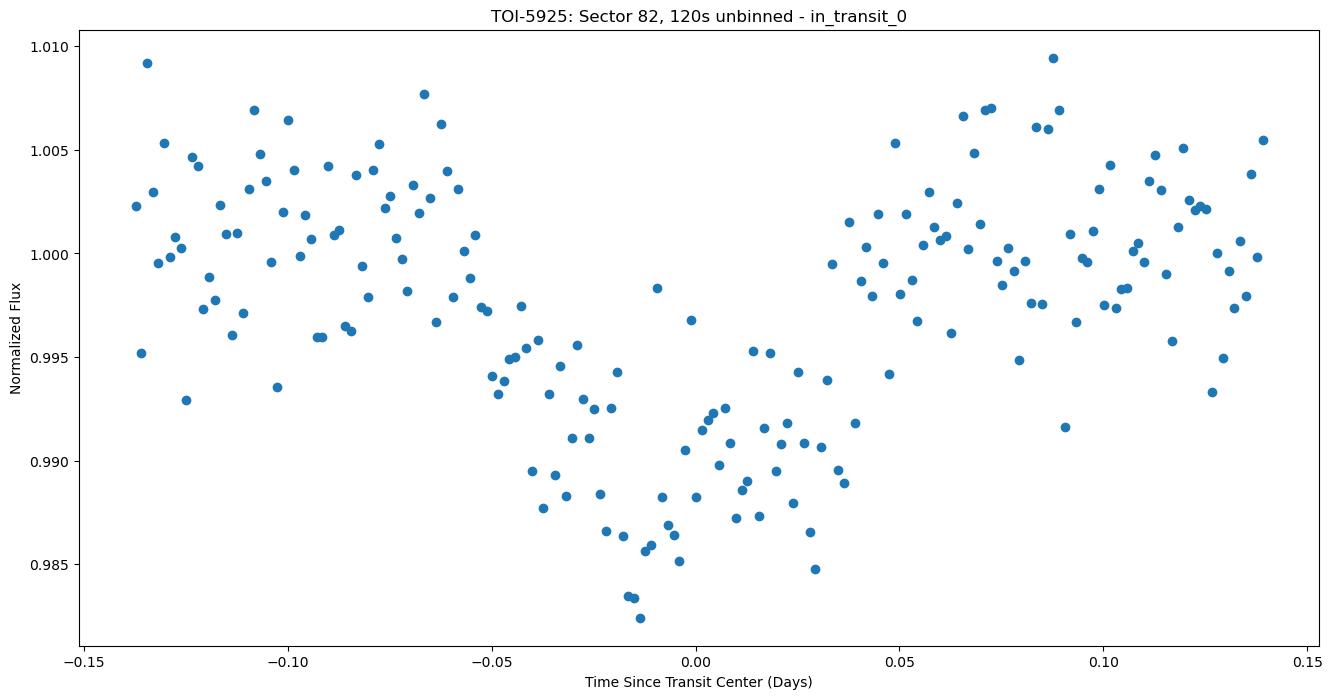

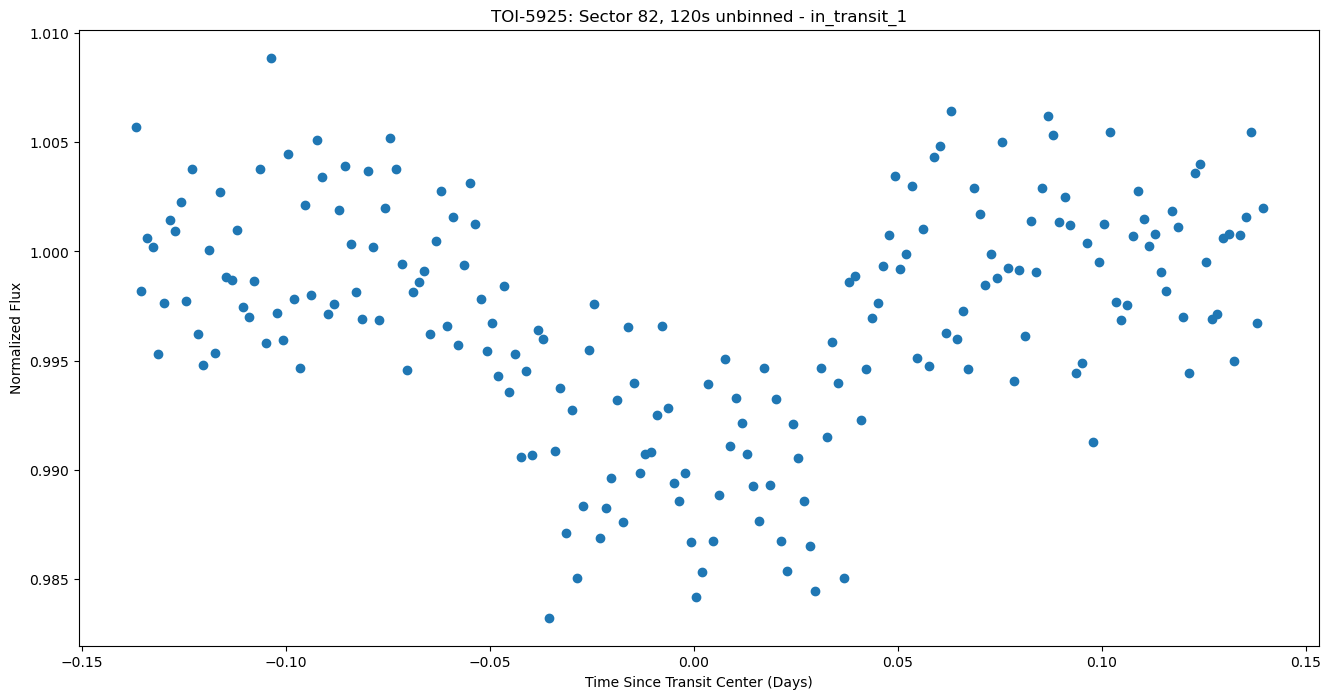

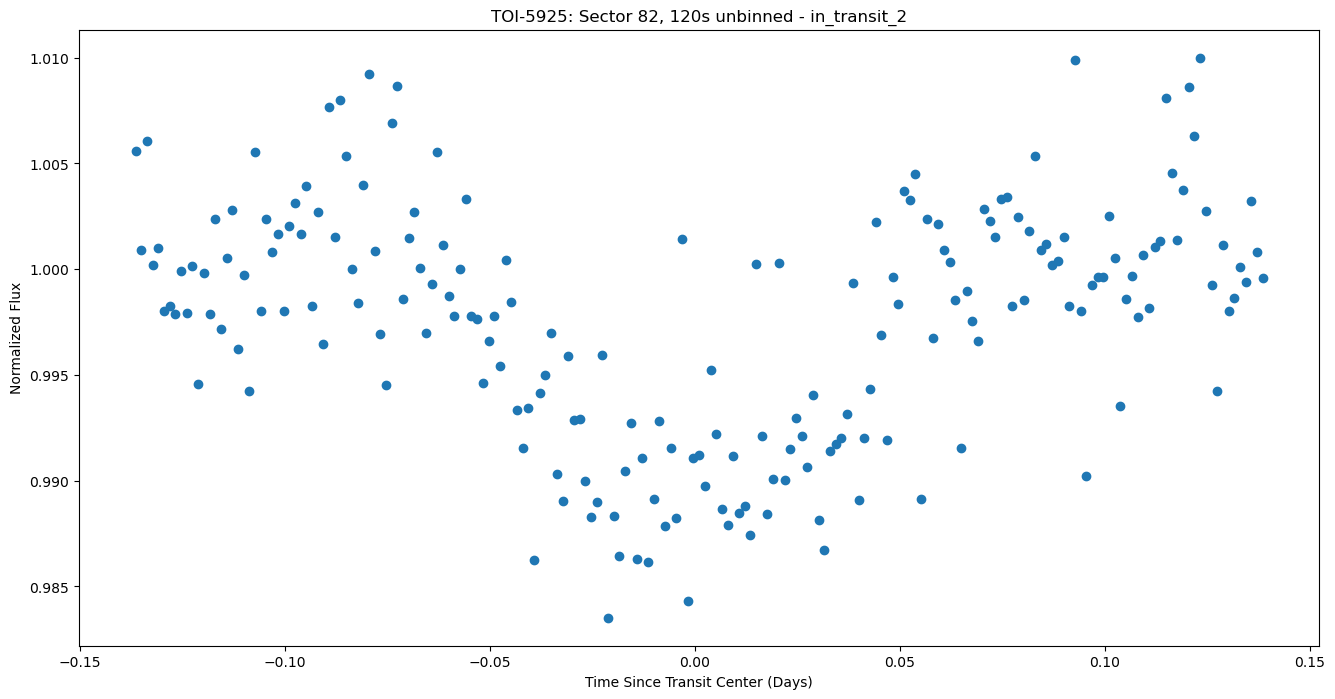

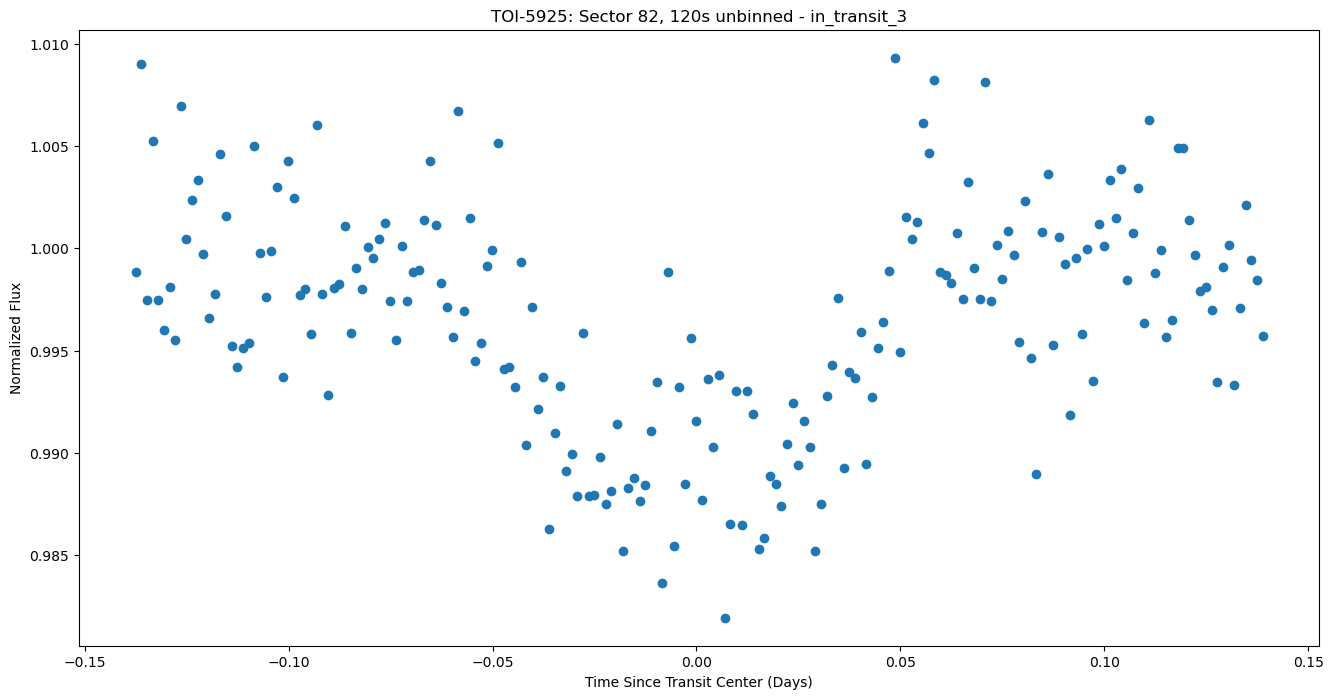

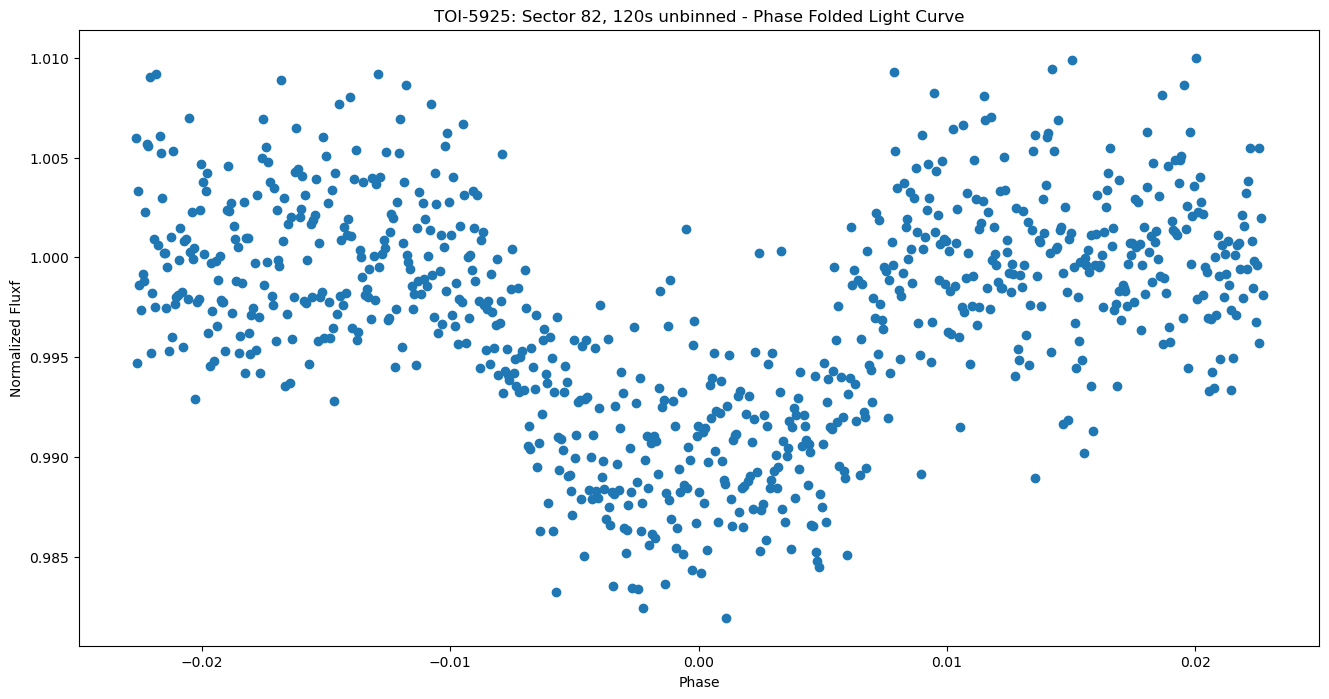

In [27]:
create_light_curve(f'TIC {ticid}', 'SPOC', 82, auto = False, exposure=120, targetname = f'TOI-{toi}', keep_secondary_eclipse=False,
                   ecosw = 0, save = True, plot = True, planet='b', published = False, qualityFlag = False, #omit_transit_index=[2],
                   outputfiles='slimflat', outputdir = outpath, tc=2459814.55, period = 6.1606297 * u.day, duration=2.218 * u.hr)

## Generating priors and SED
Before running this cell, create a directory to store the fit files and generate the prior and SED files using mkticsed. This cell will generate a separate text file containing the relevant priors and starting points. Append this to the end of the prior file generated by mkticsed, deleting the existing metallicity prior.

In [29]:
with open('tres_password.txt', 'r') as file:
    password = file.read().replace('\n', '')

tess_lcs = [1, 1] # booleans for whether or not each lightcurve is from TESS
grab_all_priors(f'TOI-{toi}', tess_lcs=tess_lcs, outpath=outpath, feh_source='tres', tres_username='schulte', tres_password=password)

Starting points:
Tc = 2459814.45684
Period = 6.1606297
Rp/Rs = 0.10114346246792226
Spectroscopic [Fe/H] prior: -0.0141 +/- 0.1014
Dilution prior: 0.0 +/- 0.0031289


## Generating scripts to run the fit

After collecting all lightcurves, change the exptimes array in the following cell and then run it to generate the final files. By default, a dilution term will be fit for the TESS bands. After running the initial fit, if this is consistent with zero, it can be removed from the fit.

In [30]:
# outpath = f'/Users/jack/Research/meep2/toi{toi}/'
exptimes = [10, 2] # exposure times in minutes of included lightcurves (by index/chronological order)
# tess_lcs = [1, 1, 1, 1] # booleans for whether or not each lightcurve is from TESS
generate_pro_file(toi, ticid, exptimes, tess_lcs=tess_lcs, outpath=outpath)
generate_SLURM_file(toi, outpath=outpath)